In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# The usual notebook preferences

%config InlineBackend.figure_format = 'svg'

import numpy
import sys
import matplotlib.pyplot as plt

sys.path.append('..')
from helper_functions import *

HTML(toggle_code("import functions"))

In [3]:
set_notebook_preferences()

## 3.3 Multi-class classification (soft max)

We will now see how to extend the logistic regression model we saw in chapter 3.2 to deal with multiple classes. Consider the $1$-of-K scheme where $y_{nk} = 0 \text{ or } 1$ denotes whether datapoint $n$ belongs to class $k$. In other words if $y_{nk}$ is written out as a matrix, each row will contain a single $1$ and all other entries will be $0$. We also need a multiclass activation funcion $f(a)$ to replace the logistic function $\sigma(a)$ which could only deal with two classes. As a reminder, the argument $a$ is a linear function of the weights and features: $a = \mathbf{w}^\top \mathbf{x}$. The generalisation of the logistic function to multiple classes is called the *softmax* function:

$$
p(y_{nk} = 1 |\{\mathbf{x}_n\}, \{\mathbf{w}_k\}) = \frac{\text{exp}(a_k)}{\sum_j \text{exp}(a_j)} = \frac{\text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)}{\sum_j \text{exp}(\mathbf{w}_j^\top \mathbf{x}_n)},
$$

where instead of a single weight vector we now have several weight vectors $\{\mathbf{w}_k\}$, one for each class. For the case $k=2$ we generally use the logistic sigmoid instead of the softmax, because the former is mathematically simpler.

The likelihood of the full dataset can then be written:

\begin{align}
p(\{y_{nk}\}|\{\mathbf{x}_n\}, \{\mathbf{w}_k\}) &= \prod_{m = 1}^N \prod_{j = 1}^K s_{mj}^{y_{mj}}\\
~\\
\end{align}

and the log-likelihood $\mathcal{L}$:

\begin{align}
\mathcal{L} &= \sum_{m = 1}^N \sum_{j = 1}^K y_{mj} \text{log}~s_{mj}
\end{align}

Where we have written $s_{mj} = \text{exp}(\mathbf{w}_j^\top \mathbf{x}_m)\big/\sum_l \text{exp}(\mathbf{w}_l^\top \mathbf{x}_m)$. Now we can proceed by gradient ascent again, which amounts to finding the derivatives of $\mathcal{L}$ with respect to the weights. The derivative of the soft-max can be shown to be

\begin{align}
\frac{\partial s_{nk}}{ \partial a_{nj}} = s_{nk}(I_{kj} - s_{nj})
\end{align}

Which together with the expression can be used to show that

\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{w}_j} = \sum^N_{n = 1} (y_{nj} - s_{nj}) \mathbf{x}_n
\end{align}

<details>
<summary>Gradient of softmax log-likelihood</summary>
<div>
    Starting from the expression

\begin{align}
\mathcal{L} &= \sum_{n = 1}^N \sum_{k = 1}^K y_{nk} \text{log}~s_{nk},
\end{align}

and taking the derivative w.r.t. $\mathbf{w}_j$ we see:


\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{w}_j} &= \sum_{n = 1}^N\sum_{k = 1}^K y_{nk} \frac{1}{s_{nk}} \frac{\partial s_{nk}}{\partial \mathbf{w}_j} = \sum_{n = 1}^N\sum_{k = 1}^K y_{nk} \frac{1}{s_{nk}} \frac{\partial s_{nk}}{\partial a_{nj}} \frac{\partial a_{nj}}{\mathbf{w}_j}\\
~\\
&= \sum_{n = 1}^N\sum_{k = 1}^K y_{nk} (I_{kj} - s_{nj}) \mathbf{x}_n\\
~\\
\end{align}

where we have used the expression

\begin{align}
\frac{\partial s_{nk}}{ \partial a_{nj}} = s_{nk}(I_{kj} - s_{nj}).
\end{align}

Then considering that for each $n$, $y_{nk}$ is $1$ for a single value of $k$ and $0$ for all other values of $k$:


\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{w}_j} &= \sum_{n = 1}^N\sum_{k = 1}^K y_{nk}(I_{kj} - s_{nj})\mathbf{x}_n\\
~\\
&= \sum_{n = 1}^N\sum_{k = 1}^K (y_{nj} - s_{nj})\mathbf{x}_n\\
\end{align}

arriving at the final result.
</div>
</details>

Now let's write down gradient ascent for the softmax as we did for the logistic function.

In [4]:
def softmax(x):
    return (np.exp(x).T/np.sum(np.exp(x), axis = 1)).T # define softmax function for convenience

def softmax_gradient_ascent(x, y, init_weights, no_steps, stepsize):
    
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1) # add 1's to the inputs as before
    
    w = init_weights.copy() # copy weights as before
    
    w_history, log_liks = [], [] # arrays for storing weights and log-liklihoods as before

    for n in range(no_steps): # in this part we optimise log-lik w.r.t. ws
        
        log_liks.append(np.sum(y*np.log(softmax(x.dot(w))))) # record current log-lik as before
        
        w_history.append(w.copy()) # record current weights as before
    
        soft_ = softmax(x.dot(w)) # using our neat convenience function
        
        dL_dw = (x.T).dot(y - soft_)/x.shape[0]
        
        w += stepsize*dL_dw # update weights and repeat
    
    return np.array(w_history), np.array(log_liks)

We can now run gradient ascent on the Iris dataset with all 3 classes. Lets start by running it with just two of the parameters, in order to visualise the results. In the below plot, each point on the graph is coloured with RGB values representing the probabilities that the model would assign to each class ($0$,$1$ and $2$ respectively) for a data point in this location. 

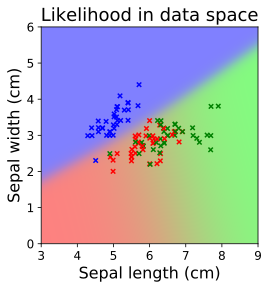

In [5]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

y_ = np.zeros(shape = (y.shape[0], 3))
y_[np.arange(y.shape[0]), y] = 1

no_train = (x.shape[0] * 3) // 4
x_train, x_test, y_train, y_test = x[:no_train, :2], x[no_train:, :2], y_[:no_train], y_[no_train:]

init_weights = np.zeros(shape = (x_train.shape[1] + 1, 3))

w_history, log_liks = softmax_gradient_ascent(x_train, y_train, init_weights, 10 ** 4, 0.05)

min_x, max_x, min_y, max_y, res = 3, 9, 0, 6, 1000
grid = np.stack(np.meshgrid(np.linspace(min_x, max_x, res), np.linspace(min_y, max_y, res)), axis = -1)
grid = grid.reshape((-1, 2))
grid = np.append(np.ones(shape = (grid.shape[0], 1)), grid, axis = 1)

probs = softmax(grid.dot(w_history[-1])).reshape((res, res, 3))
rgb_colors = np.roll(probs, -1, axis  = -1)
plt.imshow(rgb_colors, extent = [min_x, max_x, min_y, max_y], alpha = 0.5, origin='lower')
plt.scatter(x_train[:, 0], x_train[:, 1], marker = 'x', s = 20, color = np.array(['b', 'r', 'g'])[y[:no_train]])
beautify_plot({"title":r"Likelihood in data space", "x":"Sepal length (cm)", "y":"Sepal width (cm)"})
plt.show()

HTML(toggle_code())

Now that we have visualised the probabilities, we can perform our gradient-ascent algorithm on the full Iris dataset, with all the parameters, and all 3 classes. First lets see how the log-likelihood changes with step number:

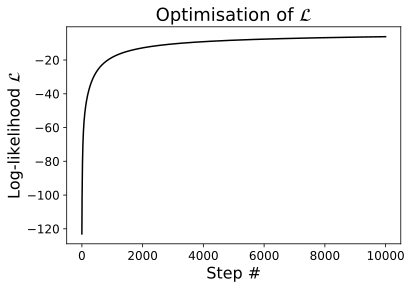

In [6]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

y_ = np.zeros(shape = (y.shape[0], 3))
y_[np.arange(y.shape[0]), y] = 1

no_train = (x.shape[0] * 3) // 4
x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y_[:no_train], y_[no_train:]

init_weights = np.zeros(shape = (x_train.shape[1] + 1, 3))

w_history, log_liks = softmax_gradient_ascent(x_train, y_train, init_weights, 10 ** 4, 0.05)
beautify_plot({"title":r"Optimisation of $\mathcal{L}$", "x":"Step #", "y":"Log-likelihood $\mathcal{L}$"})
plt.plot(log_liks, color = 'black')
plt.show()

HTML(toggle_code())

Now lets test the accuracy of our model on the test data:

In [7]:
def softmax_test_accuracy(test_x, test_y, w):
    x_ = np.append(np.ones(shape = (test_x.shape[0], 1)), test_x, axis = 1)
    y_ = softmax(x_.dot(w))
    return (np.argmax(y_, axis = 1) == np.argmax(y_test, axis = 1)).mean()

print('Classification accuracy for full iris dataset = {}%'.format(softmax_test_accuracy(x_test, y_test, w_history[-1])*100))

HTML(toggle_code())

Classification accuracy for full iris dataset = 94.73684210526315%


Having covered multi-class classification, you should now understand:

1. How the logistic regression model can be adapted to deal with multiple classes.
2. What the gradient ascent algorithm differs when dealing with multiple classes.

In [section 3.4](classification_non-linear.ipynb) we will look at how to generalise this method for non-linear logistic regression.